In [27]:
import math
import numpy as np
import pandas as pd
import plotly.express as px
import pickle
import time
import matplotlib.pyplot as plt

In [37]:
dataset = pd.read_csv('../data-sets/life-expectancy-data/LifeExpectancyData.csv')

target_column_name = 'Life expectancy '

def split_train_test(dataset, train_percentage=0.8, random_state=None):
    m, n = dataset.shape
    print("Dataset Shape:", m, n)
    indices = np.arange(m)
    if random_state is not None:
        np.random.seed(random_state)
    np.random.shuffle(indices)
    split_point = int(m * train_percentage)
    train_data = dataset.iloc[indices[:split_point]]
    test_data = dataset.iloc[indices[split_point:]]
    return train_data.reset_index(drop=True), test_data.reset_index(drop=True) 

train_data, test_data = split_train_test(dataset)

train_data = train_data.dropna()
test_data = test_data.dropna()

m, n = train_data.shape
print("Train Data Shape:", m, n)
m, n = test_data.shape
print("Test Data Shape:", m, n)

X_Train = train_data.drop(target_column_name, axis=1)
Y_Train = train_data[target_column_name]
X_Test = test_data.drop(target_column_name, axis=1)
Y_Test = test_data[target_column_name]

print(X_Train.shape, Y_Train.shape, X_Test.shape, Y_Test.shape)

Dataset Shape: 2938 22
Train Data Shape: 1327 22
Test Data Shape: 322 22
(1327, 21) (1327,) (322, 21) (322,)


In [18]:
# # Load the training data
# train_df = pd.read_csv('../data-sets/sample-data/train.csv')

# # Load the test data
# test_df = pd.read_csv('../data-sets/sample-data/test.csv')

# # Display the first few rows to verify

# train_data = train_df.dropna()
# test_data = test_df.dropna()

# print("Train Data:")
# display(train_data.head())

# print("Test Data:")
# display(test_data.head())

In [38]:
#Plotting data to see the relationship

def plot_data(train_data, target_column_name = 'Life expectancy '):  
    for column_name in train_data.columns:
        if column_name != target_column_name:
            plt.scatter(train_data[column_name], train_data[target_column_name], s=10)
            plt.xlabel(column_name)
            plt.ylabel(target_column_name)
            plt.title(f"{column_name} vs {target_column_name}")
            plt.grid(True)
            plt.show()  

# plot_data(train_data, target_column_name)   


In [39]:
def preprocess_data(X_train, X_test):
    # Separate numeric and non-numeric columns
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns
    categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns

    # Zero-score normalization for numeric columns
    mean = X_train[numeric_cols].mean()
    std = X_train[numeric_cols].std()
    X_train_norm = X_train.copy()
    X_test_norm = X_test.copy()
    X_train_norm[numeric_cols] = (X_train[numeric_cols] - mean) / std
    X_test_norm[numeric_cols] = (X_test[numeric_cols] - mean) / std

    # One-hot encoding for categorical columns
    X_train_encoded = pd.get_dummies(X_train_norm, columns=categorical_cols, dtype=int)
    X_test_encoded = pd.get_dummies(X_test_norm, columns=categorical_cols, dtype=int)

    # Align columns (in case test set is missing some categories)
    X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

    return X_train_encoded, X_test_encoded

def zero_score_normalize_data(X_train, X_test):
    """
    Zero Score Normalization: x = x − μ / σ
    """
    mean = np.mean(X_train, axis = 0) #We don't consider test data while calculating mean because we want to keep the training unbiased of test data
    std = np.std(X_train, axis = 0)
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std
    return X_train, X_test

X_Train, X_Test = preprocess_data(X_Train, X_Test)
print(X_Train.head())



       Year  Adult Mortality  infant deaths   Alcohol  percentage expenditure  \
1  1.489304        -1.157974      -0.172444 -1.119690               -0.397449   
2  0.757248        -0.456246      -0.268164  0.358924               -0.152827   
3 -1.438919        -1.205819      -0.260187  1.854905                0.733050   
4  1.001267        -0.894826      -0.268164  1.495175                0.885508   
6  1.001267        -1.142025      -0.228281  0.971706               -0.131444   

   Hepatitis B  Measles       BMI   under-five deaths      Polio  ...  \
1     0.742079 -0.226320 -1.798417           -0.174744  0.649079  ...   
2     0.624681 -0.227296  1.191003           -0.263459  0.517047  ...   
3     0.115954 -0.226515  0.679255           -0.263459  0.561058  ...   
4     0.663814 -0.227198  1.033932           -0.269374  0.693089  ...   
6    -1.292829  1.016877  1.079533           -0.239802 -0.495192  ...   

   Country_Turkmenistan  Country_Uganda  Country_Ukraine  Country_Uruguay 

In [ ]:
# X_Train = np.expand_dims(X_Train, axis=-1)
# X_Test = np.expand_dims(X_Test, axis=-1)


# print(X_Train.shape)
# print(X_Test.shape)


(699, 1)
(300, 1)


In [49]:
class LinearRegression:
    def __init__(self, learning_rate, max_iterations ,convergence_threshold):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.convergence_threshold = convergence_threshold
        self.w = None
        self.b = None
    
    def predict(self, X):
        return np.dot(X, self.w) + self.b
    
    def compute_cost(self, X, y):
        m = len(y)
        y_pred = self.predict(X)
        cost = (1 / (2 * m)) * np.sum(np.square(y_pred - y))
        return cost

    def derivative_w(self, X, y, y_pred, m):
        return 1/m * np.dot(X.T, (y_pred - y))

    def derivative_b(self, y, y_pred, m):
        return 1/m * np.sum(y_pred - y)
    
    def gradient_descent(self, X, y):
        m, n = X.shape
        self.w = np.random.randn(n)
        self.b = 0
        self.cost_progression = []
        self.iteration_progression = []
        for i in range(self.max_iterations):
            y_pred = self.predict(X)
            self.w -= self.learning_rate * self.derivative_w(X, y, y_pred, m)
            self.b -= self.learning_rate * self.derivative_b(y, y_pred, m)
            
            if i % 100 == 0:
                cost = self.compute_cost(X, y)
                self.cost_progression.append(cost)
                self.iteration_progression.append(i+1)
                print(f"Iteration {i}, Cost: {cost}")
            
            if cost < self.convergence_threshold:
                print(f"Converged at iteration {i}")
                break
        
    def plot(self, x_data, y_data, x_label, y_label, title ):
        plt.plot(x_data, y_data)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title)
        plt.show()
        
    def fit(self, X, y):
        print(X.shape)
        print(y.shape)
        self.gradient_descent(X, y)
        self.plot(self.iteration_progression, self.cost_progression, "Iteration", "Cost", "Cost Progression")

    # def evaluate(self, X, y):
    #     y_pred = self.predict(X)
    #     plt.scatter(test_data['x'], test_data['y'], s=10)
    #     plt.plot(test_data['x'], y_pred, color='red')

    def evaluate(self, X_Test, Y_Test, title="Predicted vs Actual"):
        y_pred = self.predict(X_Test)
        # plt.figure(figsize=(6, 6))
        plt.scatter(Y_Test, y_pred, s=10)
        plt.plot([Y_Test.min(), Y_Test.max()], [Y_Test.min(), Y_Test.max()], color='red', linestyle='--')  # Perfect line
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title(title)
        plt.grid(True)  
        plt.show()    
       
    


(1327, 154)
(1327,)
(1327, 154)
(1327,)
Iteration 0, Cost: 2378.2777396254037
Iteration 100, Cost: 1673.555361265319
Iteration 200, Cost: 1183.374137986943
Iteration 300, Cost: 840.9653074590686
Iteration 400, Cost: 601.208417566584
Iteration 500, Cost: 433.0574512389489
Iteration 600, Cost: 314.96239336710545
Iteration 700, Cost: 231.9010112273291
Iteration 800, Cost: 173.37936912762262
Iteration 900, Cost: 132.05857553795508
Iteration 1000, Cost: 102.80270585716747
Iteration 1100, Cost: 82.01573126221439
Iteration 1200, Cost: 67.17870701278221
Iteration 1300, Cost: 56.526378019929446
Iteration 1400, Cost: 48.82106500782304
Iteration 1500, Cost: 43.194506854704755
Iteration 1600, Cost: 39.037203211418124
Iteration 1700, Cost: 35.92097128684093
Iteration 1800, Cost: 33.544733455765524
Iteration 1900, Cost: 31.69655667102761
Iteration 2000, Cost: 30.227063689672484
Iteration 2100, Cost: 29.03080317295203
Iteration 2200, Cost: 28.033191309976925
Iteration 2300, Cost: 27.181354717162847
I

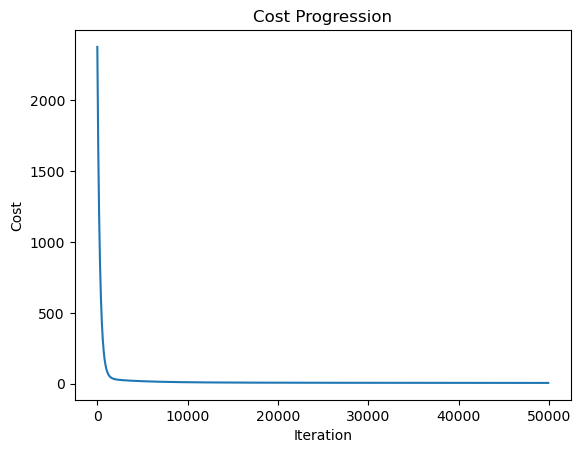

Training Time:  22.227354049682617


In [59]:
linear_reg = LinearRegression(learning_rate=0.001, max_iterations=50000, convergence_threshold=1e-6)
print(X_Train.shape)
print(Y_Train.shape)
start_time = time.time()
linear_reg.fit(X_Train, Y_Train)
elapsed_time = time.time() - start_time
print( "Training Time: ", elapsed_time)


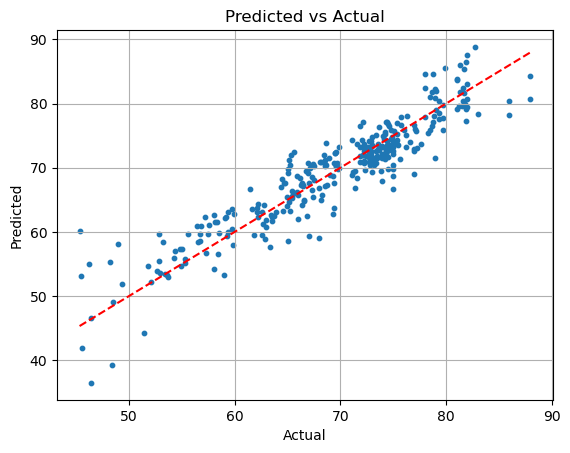

In [60]:
linear_reg.evaluate(X_Test=X_Test, Y_Test=Y_Test)